Hashing - trying multiple options

For each Hashing option we have 3 functions:

1) Compute hash function

2) Add to hash table

3) Get in hash table

4) Get_closest to find best matches for a given snippet

Notes:
Piano notes go from midi numbers 21 to 108

Options:
Option 1: tree like structure where each level is whether a note is present in the sequence or how many times
Option 2: Hash tabel for a specific combination of notes. (Exact matches of 4 notes)
Option 3: C++ hashmap? (For less space than option 2, but probably more time)

1 millesecond for finding the best match
1 millesecond for synthesizing & finding

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import re
import time
import datetime

# import sounddevice as sd
# from scipy.io import wavfile

from multiprocess import Pool
import functools
import pdb

from collections import defaultdict
from typing import NewType

import sys
sys.path.insert(1, './functions_v8')

from workflow import *
from read import *
from similarity import *
from helper import *
from display import *

Option 1: tree like structure where each level is whether a note is present in the sequence or how many times

In [2]:
class note_tree():
    
    def __init(self):
        # self.root = 
        pass
        
    def add_tree(self, snippet):
        pass
        
    

Option 2: Hash tabel for a specific combination of notes. BUT need to check all variations for error :(
(aka 3^num_unique_notes)
Can work if we have less notes? Like 4? Then no checking mistakes just where max # of those 4 notes exist.
Each element of hash table is linkedlist of all timestamps that have given 4 notes.

Worries: still too much time! Esp if want to align for _every_ note.
also, using sorted might remove a lot of matches/ less tolerance to mistakes

In [2]:
# class hash_4notes():
#     def __init__(self):
#         self.table = np.empty(88*88*88*88,dtype=object) # number of possible combinations of 4 notes (88C4)

#     def hash_function(self,snippet):
        
#         # step 1: convert snippet to array (list) of ints
#         # snippet is [[timestamp,note,vel],[timestamp,note,vel],...]
#         snippet = np.array(snippet)
#         int_snippet = snippet[:,1]

#         # step 2: convert midi numbers 21-108 to 0-87
#         int_snippet -= 21
        
#         # step 3: sort values
#         int_snippet.sort() # Current version includes table size for unsorted - overkill
# #         print(int_snippet)

#         # step 4: compute hash function - find position for given *combination* of notes
#         hash_value = 0
#         multiplier = [109736,3828,88,1] # 88C3, 88C2, 88C1, 88C0. Number of note combinations starting with given snip....
#         for i,note in enumerate(int_snippet):
#             hash_value += note * multiplier[i]
#         return hash_value

#     def add(self,snippet):
#         # step 1: compute hash function
#         hash_val = self.hash_function(snippet)

#         # step 2: add to table at index hash_val
#         if self.table[hash_val] is None:
#             self.table[hash_val] = [snippet[-1][0]]
#         else:
#             self.table[hash_val].append(snippet[-1][0])
            
#     def get(self,snippet): 
#         # step 1: compute hash function
#         hash_val = self.hash_function(snippet)

#         # step 2: check table at given position
#         # and return list of all matching timestamps
#         return self.table[hash_val]
            
#     def get_closest(self,snippet,sourceTime=None): # for longer snippets
#         if sourceTime is None:
#             sourceTime = snippet[-2][0]
#         # step 1: initialize matches
#         match_timestamps = []
#         match_timestamps_all = []
#         # step 2: split into 4 note long snippets
#         for i in range(4,len(snippet)):
#             curr = snippet[i-4:i]
#             dist = sourceTime - snippet[i-1][0]
#             # step 3: compute hash function
#             hash_val = self.hash_function(curr)

#             # step 4: check table at given position and add to matches
#             if self.table[hash_val] is not None:
#                 match_timestamps.append(np.array(self.table[hash_val])+dist)
#                 match_timestamps_all.extend(np.array(self.table[hash_val])+dist)
            
#         # step 5: consolidate matches
#         if not match_timestamps_all:
#             return match_timestamps_all
#         # option 1 - send all results - had too many repeats
# #         return match_timestamps_all 
#         # option 2 - remove repeats (within 50ms)
#         match_timestamps_all.sort()
#         match_2 = [match_timestamps_all[0]]
#         for i in match_timestamps_all:
#             if i > match_2[-1]+50:
#                 match_2.append(i)
#         return match_2

# # Testing functions
# hash_table = hash_4notes()
# hash_table.add([[0,22],[0,23],[0,24],[0,25]])
# hash_table.add([[0,108],[0,108],[0,108],[100,108]])
# print(hash_table.get([[0,22],[0,23],[0,24],[0,25]]))
# print(hash_table.get([[0,22],[0,23],[0,24],[0,24]]))
# print(hash_table.get([[0,25],[0,23],[0,22],[0,24]]))
# print(hash_table.get([[0,108],[0,108],[0,108],[100,108]]))
# print(hash_table.get_closest(notes[:5]))


In [2]:
# Setting up parameters to run the matching algorithm

midiPath = './midi-recordings/ladispute.txt'
notes = midi_to_timeseries(midiPath)

# hyperparameters
zero_penalty = 1
length_incentive = 500000 # 50 seconds yields 10% increase in score
max_offset = 600
timestamp_max_before_source = 5000 #ms behing the source timestamp
min_dist_const = 400 # acceptable time difference for same note
initial_alignment = "last note in source to match in target"
realignment = "mean offset of notes within max_offset dist - done once"
note_scoring = "penalize within min_dist"

# parameters
minNotes = 8
maxNotes = 200 # max length of snippet to be calculated
minTime = 1500 # min time in ms
maxTime = 30000 # if more matches, increase snippet length
thresh = 0.7
start = 191400
skip = 10
end = 365000
disp = False
curr_times = np.arange(start, end, skip) # list of "current" times for which we are searching for matches


In [3]:
def calculate_similarity_time(notes,source_id,currTime,timestamp_max_before_source=5000,zero_penalty=1,length_incentive=500000,max_offset=600,min_dist_const=400,skip=100,disp=False):
    """ Function that calls musical similarity on targets generated for a source_id.
        Target snips start at every 100 ms, and has same time length as source.
    
    Args:
        notes: list of all notes from a recording [[t,note,vel],[t,note,vel],[t,note,vel],...]
        source_id: indices of note array corresponding to current time snippet (source_id_start>source_id_end) 
                   [source_id_start, source_id_end]
        currTime: time stamp at which we are searching for matches (ms)
        skip: interval at which to iterate over target timestamps
        disp: boolean whether to print each match (defaults True)
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
    
    matches = []
    last_id_end = 0 # track previous end index of target
    last_id_start = 0
    source_id_start, source_id_end = source_id
    source_end = notes[source_id_end][0] # start and end time stamps of source
    length_ms = currTime - source_end #in milliseconds
    last_id_end = 0
    
    found_timestamps = np.array(hash_table.get_closest(notes[source_id_end:source_id_start]))
    
    for target in found_timestamps:
        target_start = target-100
        while target_start < target+101:
            if target_start >= currTime-timestamp_max_before_source:
                continue
                
            target_end = target_start - length_ms # pick target_end by time length of course snip

            # finding new end index
            for i in range(last_id_end,len(notes)): # should be better way to do this; store time and index both in hash table?
                if notes[i][0] >= target_end:
                    target_id_end = i
                    break

            # finding new start index
            for i in range(target_id_end,len(notes)):
                if notes[i][0] > target_start:
                    target_id_start = i
                    break

            if target_id_end > target_id_start-4:
                last_id_end = target_id_end
                last_id_start = target_id_start
                target_start += skip
                continue
            if target_id_end == last_id_end and last_id_start == target_id_start:
                target_start += skip
                continue

            lm1,lm2,mo1,mo2,score = two_way_similarity(notes[source_id_end:source_id_start], notes[target_id_end:target_id_start],zero_penalty=zero_penalty,length_incentive=length_incentive,max_offset=max_offset,min_dist_const=min_dist_const,disp=disp)

            if score:
                if score>0.7:
    #                 count += 1
                    # Dsiplaying matches > 0.7 if disp is True
                    if disp:
                        display_snippet_plot(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, source_end, notes[target_id_end][0])
                        # play_match(piano_audio, currTime, source_end, target_start, target_end)
                        # predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, currTime, target_start)
                        # time.sleep(5)

                if score>0.5:
                    target_time = target_start

                    # case 1 - good alignment of source snippet
                    if lm1 >= source_id_start - source_id_end - 2:
                        target_time = notes[target_id_start-1][0] + int(mo2) + (currTime - notes[source_id_start-1][0])

                    # case 2 - run again with target slightly ahead?
                    elif lm2 >= target_id_start - target_id_end - 2:
                        if currTime - notes[source_id_end+lm1][0] < 1:
                            print("oops something went wrong with time calculations - might end in infinite loop")
                        target_start += currTime - notes[source_id_end+lm1][0]
                        continue

                    # In all cases where good score and we do not rerun,
                    # Find optimal timestamp and store the match
                    target_time = notes[target_id_start-1][0] - int(mo2) + (currTime - notes[source_id_start-1][0])    
                    if target_time<currTime-timestamp_max_before_source:
                        matches.append([currTime, target_time, score, source_id_start, source_id_end, time_to_index(notes, target_time), target_id_end])
        
            last_id_end = target_id_end
            last_id_start = target_id_start
            target_start += skip
        
    return matches


def find_matches_at_timestamp_rev(i,notes,minNotes,minTime,maxNotes,maxTime,thresh,timestamp_max_before_source=5000,zero_penalty=1,length_incentive=500000,max_offset=600,min_dist_const=400,prev_matches=None,disp=False):
    """Function that finds similarity from lengths minNotes to maxNotes ...
    
    Args:
        i:
        notes:
        minNotes:
        minTime:
        maxNotes:
        maxTime:
        thresh:
        disp:
    
    Returns:
        sims_arr: np array of every match >0.5 found of the form -
            ['source_timestamp', 'target_timestamp','score',
            'source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time']
    
    """
    
    sims_arr = []
#     print("\r",end="")
#     print("i:",i,end=" ")
    offset = 0
    numSourceNotes = maxNotes
    sourceTime = maxTime
    
    start_index = np.argwhere(notes[:,0] > i)
    if start_index.any():
        start_index = start_index[0]
    else:
        return np.array([])
    
    while sourceTime > minTime:
        sourceId = get_source_notes_rev(notes, i, start_index, minNotes, numSourceNotes, sourceTime-offset)
        if not sourceId.any():
            break

        # num notes in source snippet
        numSourceNotes = (sourceId[0] - sourceId[1])
        # total time in ms in source snippet
        sourceTime = i - notes[sourceId[1]][0]
        
        if prev_matches is None:
            print("Redirecting to regular find_matches_at_timestamp without speedup",end="")
            sim = calculate_similarity_time(notes,sourceId,i,timestamp_max_before_source=timestamp_max_before_source,zero_penalty=zero_penalty,length_incentive=length_incentive,max_offset=max_offset,min_dist_const=min_dist_const,disp=disp)
        else:
            sim = calculate_similarity_time_speedup(notes,sourceId,i,timestamp_max_before_source=timestamp_max_before_source,zero_penalty=zero_penalty,length_incentive=length_incentive,max_offset=max_offset,min_dist_const=min_dist_const,prev_matches=prev_matches,disp=disp)
        for match in sim:
            match.append(numSourceNotes)
            match.append(sourceTime)
        sims_arr.extend(sim)
        if len(sim) != 0:
            break
            
        offset += 500
        
    start_index = np.argwhere(notes[:,0] > i)
    if start_index.any() and start_index[0] >= 4:
        start_index = start_index[0][0]
        to_add = notes[start_index-4:start_index]
#         print(to_add)
        s = hash_table[to_add]
        if s is None or s[-1] < i-50 and s[-1] != to_add[-1][0]:
            hash_table.add(to_add)

    return np.array(sims_arr)

In [4]:
'''
first layer:
    key: 4-note snippet
    value: defaultdict
    
second layer:
    key: int (time taken for 10 notes)
    value: timestamp
'''
hash_table = defaultdict(lambda:defaultdict(list)) # Initializing empty hash table before every run

# Adding first playthrough to hash table - run this before next cell everytime!!

'''
Adding 4-note snippet as 1st key;
10-note snippet time length (nearest 20ms) as 2nd key;
timestamp (set) as value.

Note: When search: searching 9, 10, 11 notes with both bounds of 20ms.
'''
# start measuring time to check time to hash
start_time_hash = datetime.datetime.now()
 
# iterating through time (what we will be doing)
for i in range(0,191400,10):
    start_index = np.argwhere(notes[:,0] > i)
    if start_index.any() and start_index[0][0] >= 4:
        start_index = start_index[0][0]
        to_add = notes[start_index-4:start_index]
        key = tuple(to_add[:,1])
        ten_notes = notes[start_index-min(10, start_index):start_index]
        ten_notes_time = ten_notes[-1][0] - ten_notes[0][0]
        rounded_time = int(round(ten_notes_time / 20) * 20)
#         print(to_add)
        s = hash_table[key][rounded_time] # Ran in 0.38 seconds
        
        if notes[start_index-1][0]>i-100:  # if pause for more than 5 seconds, not including in hash table
            if (not len(s)) or (s[-1] < i-50 and s[-1] != to_add[-1][0]):
                # append to hash_table for future checking
                hash_table[key][rounded_time].append(to_add[-1][0])
            
            
            # how much used space is okay?
            # do we need resolution less than 100ms?
        
# calculating time taken for above code to run
end_time_hash = datetime.datetime.now()
timedelta_hash = end_time_hash-start_time_hash
runtime_hash = timedelta_hash.total_seconds()
print("Ran in {:.2f} seconds".format(runtime_hash))

# # check size of each table entry ( to see distribution )
used_entries = 0
for snippet in hash_table.values():
    for l in snippet.keys():
        pass
#         if len(snippet[l]) > 30:
#             print(len(snippet[l]))
#     if i is not None:
# #         print(len(i))
#         used_entries += 1

Ran in 0.88 seconds


In [14]:

    

# test get_closest and how well it finds matches
# start measuring time to check time to find match
start_time_hash_find = datetime.datetime.now() # Ran in 5.09 seconds without print statements
# test_len = 10
test_len = 4
percentage_found = len(range(191400,365000,10))
avg_num_matches = 0
# for i in range(191400,365000,10):
for i in range(191400,365000,10):
# for start_index in range(762, len(notes)):
    start_index = np.argwhere(notes[:,0] > i)
#     i = notes[start_index][0]
    if start_index.any() and start_index[0][0] >= test_len:
#     if start_index >= test_len:
        start_index = start_index[0][0]
        to_find = notes[start_index-test_len:start_index]
        expected = i-191400
        
        print("i: {}".format(i))
        print("start index: {}".format(start_index))
        
#         found_timestamps = np.array(hash_table.get_closest(to_find,i))
        key = tuple(to_find[:,1])
        ten_notes = notes[start_index-min(10, start_index):start_index]
        ten_notes_time = ten_notes[-1][0] - ten_notes[0][0]
        nine_notes = notes[start_index-min(9, start_index):start_index]
        nine_notes_time = ten_notes[-1][0] - ten_notes[0][0]
        eleven_notes = notes[start_index-min(11, start_index):start_index]
        eleven_notes_time = ten_notes[-1][0] - ten_notes[0][0]
        
        print("key is: {}".format(key))
        
        def rounding(length):
            if length / 20 < round(length / 20):
                rounded_time_1, rounded_time_2 = int((round(length / 20) - 1) * 20), int(round(length / 20) * 20)
            else:
                rounded_time_1, rounded_time_2 = int(round(length / 20) * 20), int((round(length / 20) + 1) * 20)
            return rounded_time_1, rounded_time_2

        nine_t_1, nine_t_2 = rounding(nine_notes_time)
        ten_t_1, ten_t_2 = rounding(ten_notes_time)
        eleven_t_1, eleven_t_2 = rounding(eleven_notes_time)
        
#         print("nine_t_1, nine_t_2: {}, {}".format(nine_t_1, nine_t_2))
#         print("ten_t_1, ten_t_2: {}, {}".format(ten_t_1, ten_t_2))
#         print("eleven_t_1, eleven_t_2: {}, {}".format(eleven_t_1, eleven_t_2))
        
        found_timestamps = set()
        for t in hash_table[key][nine_t_1]:
            if t < i:
                print("in nine t 1, add {}".format(t))
                found_timestamps.add(t)
        for t in hash_table[key][nine_t_2]:
            if t < i:
                print("in nine t 2, add {}".format(t))
                found_timestamps.add(t)
        for t in hash_table[key][ten_t_1]:
            if t < i:
                print("in ten t 1, add {}".format(t))
                found_timestamps.add(t)
        for t in hash_table[key][ten_t_2]:
            if t < i:
                print("in ten t 2, add {}".format(t))
                found_timestamps.add(t)
        for t in hash_table[key][eleven_t_1]:
            if t < i:
                print("in eleven t 1, add {}".format(t))
                found_timestamps.add(t)
        for t in hash_table[key][eleven_t_2]:
            if t < i:
                print("in eleven t 2, add {}".format(t))
                found_timestamps.add(t)
        found_timestamps = np.array(list(found_timestamps))
            
        
        avg_num_matches += found_timestamps.size
        t1 = np.argwhere(found_timestamps > expected+100)
        t2 = np.argwhere(found_timestamps < expected-100)
        if t1.size == 0:
            t1 = [[found_timestamps.size]]
        if t2.size == 0:
            t2 = [[-1]]
        if t1[0][0]-1 >= t2[-1][0]+1:
            pass # found
        else:
            percentage_found -= 1
#             print("i:",i, end = " ")
#             print("Expected:",expected, end = " ")
#             print("NOT FOUND :(")
# #             print(t1,t2)
#             print("\t",found_timestamps)
avg_num_matches /= len(range(191400,365000,10))
percentage_found = (percentage_found*100)/len(range(191400,365000,10))
print("Percentage expected timestamps within 100ms found: {:.2f}".format(percentage_found)) # 97.15
print("On average each timestamp gets {:.2f} number of matches".format(avg_num_matches)) # 23.97

# calculating time taken for above code to run
end_time_hash_find = datetime.datetime.now()
timedelta_hash_find = end_time_hash_find-start_time_hash_find
runtime_hash_find = timedelta_hash_find.total_seconds()
print("Ran in {:.2f} seconds".format(runtime_hash_find))
print("Number of used entries:",used_entries)


i: 191400
start index: 758
key is: (75, 55, 60, 72)
in nine t 2, add 172358
in ten t 2, add 172358
in eleven t 2, add 172358
i: 191410
start index: 758
key is: (75, 55, 60, 72)
in nine t 2, add 172358
in ten t 2, add 172358
in eleven t 2, add 172358
i: 191420
start index: 758
key is: (75, 55, 60, 72)
in nine t 2, add 172358
in ten t 2, add 172358
in eleven t 2, add 172358
i: 191430
start index: 758
key is: (75, 55, 60, 72)
in nine t 2, add 172358
in ten t 2, add 172358
in eleven t 2, add 172358
i: 191440
start index: 758
key is: (75, 55, 60, 72)
in nine t 2, add 172358
in ten t 2, add 172358
in eleven t 2, add 172358
i: 191450
start index: 758
key is: (75, 55, 60, 72)
in nine t 2, add 172358
in ten t 2, add 172358
in eleven t 2, add 172358
i: 191460
start index: 758
key is: (75, 55, 60, 72)
in nine t 2, add 172358
in ten t 2, add 172358
in eleven t 2, add 172358
i: 191470
start index: 758
key is: (75, 55, 60, 72)
in nine t 2, add 172358
in ten t 2, add 172358
in eleven t 2, add 172358


i: 204460
start index: 804
key is: (59, 59, 55, 50)
i: 204470
start index: 804
key is: (59, 59, 55, 50)
i: 204480
start index: 804
key is: (59, 59, 55, 50)
i: 204490
start index: 804
key is: (59, 59, 55, 50)
i: 204500
start index: 804
key is: (59, 59, 55, 50)
i: 204510
start index: 804
key is: (59, 59, 55, 50)
i: 204520
start index: 804
key is: (59, 59, 55, 50)
i: 204530
start index: 804
key is: (59, 59, 55, 50)
i: 204540
start index: 804
key is: (59, 59, 55, 50)
i: 204550
start index: 804
key is: (59, 59, 55, 50)
i: 204560
start index: 804
key is: (59, 59, 55, 50)
i: 204570
start index: 804
key is: (59, 59, 55, 50)
i: 204580
start index: 804
key is: (59, 59, 55, 50)
i: 204590
start index: 804
key is: (59, 59, 55, 50)
i: 204600
start index: 804
key is: (59, 59, 55, 50)
i: 204610
start index: 804
key is: (59, 59, 55, 50)
i: 204620
start index: 804
key is: (59, 59, 55, 50)
i: 204630
start index: 804
key is: (59, 59, 55, 50)
i: 204640
start index: 804
key is: (59, 59, 55, 50)
i: 204650
st

i: 214990
start index: 837
key is: (59, 55, 59, 55)
in nine t 2, add 12230
in nine t 2, add 82460
in ten t 2, add 12230
in ten t 2, add 82460
in eleven t 2, add 12230
in eleven t 2, add 82460
i: 215000
start index: 837
key is: (59, 55, 59, 55)
in nine t 2, add 12230
in nine t 2, add 82460
in ten t 2, add 12230
in ten t 2, add 82460
in eleven t 2, add 12230
in eleven t 2, add 82460
i: 215010
start index: 837
key is: (59, 55, 59, 55)
in nine t 2, add 12230
in nine t 2, add 82460
in ten t 2, add 12230
in ten t 2, add 82460
in eleven t 2, add 12230
in eleven t 2, add 82460
i: 215020
start index: 837
key is: (59, 55, 59, 55)
in nine t 2, add 12230
in nine t 2, add 82460
in ten t 2, add 12230
in ten t 2, add 82460
in eleven t 2, add 12230
in eleven t 2, add 82460
i: 215030
start index: 837
key is: (59, 55, 59, 55)
in nine t 2, add 12230
in nine t 2, add 82460
in ten t 2, add 12230
in ten t 2, add 82460
in eleven t 2, add 12230
in eleven t 2, add 82460
i: 215040
start index: 837
key is: (59, 

i: 221320
start index: 862
key is: (53, 65, 60, 56)
i: 221330
start index: 862
key is: (53, 65, 60, 56)
i: 221340
start index: 862
key is: (53, 65, 60, 56)
i: 221350
start index: 862
key is: (53, 65, 60, 56)
i: 221360
start index: 862
key is: (53, 65, 60, 56)
i: 221370
start index: 862
key is: (53, 65, 60, 56)
i: 221380
start index: 862
key is: (53, 65, 60, 56)
i: 221390
start index: 862
key is: (53, 65, 60, 56)
i: 221400
start index: 862
key is: (53, 65, 60, 56)
i: 221410
start index: 862
key is: (53, 65, 60, 56)
i: 221420
start index: 862
key is: (53, 65, 60, 56)
i: 221430
start index: 862
key is: (53, 65, 60, 56)
i: 221440
start index: 862
key is: (53, 65, 60, 56)
i: 221450
start index: 862
key is: (53, 65, 60, 56)
i: 221460
start index: 862
key is: (53, 65, 60, 56)
i: 221470
start index: 862
key is: (53, 65, 60, 56)
i: 221480
start index: 862
key is: (53, 65, 60, 56)
i: 221490
start index: 862
key is: (53, 65, 60, 56)
i: 221500
start index: 862
key is: (53, 65, 60, 56)
i: 221510
st

i: 233690
start index: 905
key is: (55, 48, 51, 55)
i: 233700
start index: 905
key is: (55, 48, 51, 55)
i: 233710
start index: 905
key is: (55, 48, 51, 55)
i: 233720
start index: 905
key is: (55, 48, 51, 55)
i: 233730
start index: 905
key is: (55, 48, 51, 55)
i: 233740
start index: 905
key is: (55, 48, 51, 55)
i: 233750
start index: 905
key is: (55, 48, 51, 55)
i: 233760
start index: 905
key is: (55, 48, 51, 55)
i: 233770
start index: 905
key is: (55, 48, 51, 55)
i: 233780
start index: 905
key is: (55, 48, 51, 55)
i: 233790
start index: 905
key is: (55, 48, 51, 55)
i: 233800
start index: 905
key is: (55, 48, 51, 55)
i: 233810
start index: 905
key is: (55, 48, 51, 55)
i: 233820
start index: 905
key is: (55, 48, 51, 55)
i: 233830
start index: 905
key is: (55, 48, 51, 55)
i: 233840
start index: 905
key is: (55, 48, 51, 55)
i: 233850
start index: 905
key is: (55, 48, 51, 55)
i: 233860
start index: 905
key is: (55, 48, 51, 55)
i: 233870
start index: 905
key is: (55, 48, 51, 55)
i: 233880
st

i: 245580
start index: 953
key is: (58, 55, 75, 63)
i: 245590
start index: 953
key is: (58, 55, 75, 63)
i: 245600
start index: 953
key is: (58, 55, 75, 63)
i: 245610
start index: 953
key is: (58, 55, 75, 63)
i: 245620
start index: 953
key is: (58, 55, 75, 63)
i: 245630
start index: 953
key is: (58, 55, 75, 63)
i: 245640
start index: 953
key is: (58, 55, 75, 63)
i: 245650
start index: 953
key is: (58, 55, 75, 63)
i: 245660
start index: 953
key is: (58, 55, 75, 63)
i: 245670
start index: 953
key is: (58, 55, 75, 63)
i: 245680
start index: 953
key is: (58, 55, 75, 63)
i: 245690
start index: 954
key is: (55, 75, 63, 50)
i: 245700
start index: 954
key is: (55, 75, 63, 50)
i: 245710
start index: 956
key is: (63, 50, 74, 62)
i: 245720
start index: 956
key is: (63, 50, 74, 62)
i: 245730
start index: 956
key is: (63, 50, 74, 62)
i: 245740
start index: 956
key is: (63, 50, 74, 62)
i: 245750
start index: 956
key is: (63, 50, 74, 62)
i: 245760
start index: 956
key is: (63, 50, 74, 62)
i: 245770
st

i: 260680
start index: 1013
key is: (72, 60, 55, 51)
i: 260690
start index: 1013
key is: (72, 60, 55, 51)
i: 260700
start index: 1013
key is: (72, 60, 55, 51)
i: 260710
start index: 1013
key is: (72, 60, 55, 51)
i: 260720
start index: 1013
key is: (72, 60, 55, 51)
i: 260730
start index: 1013
key is: (72, 60, 55, 51)
i: 260740
start index: 1013
key is: (72, 60, 55, 51)
i: 260750
start index: 1013
key is: (72, 60, 55, 51)
i: 260760
start index: 1013
key is: (72, 60, 55, 51)
i: 260770
start index: 1013
key is: (72, 60, 55, 51)
i: 260780
start index: 1013
key is: (72, 60, 55, 51)
i: 260790
start index: 1013
key is: (72, 60, 55, 51)
i: 260800
start index: 1013
key is: (72, 60, 55, 51)
i: 260810
start index: 1013
key is: (72, 60, 55, 51)
i: 260820
start index: 1013
key is: (72, 60, 55, 51)
i: 260830
start index: 1013
key is: (72, 60, 55, 51)
i: 260840
start index: 1013
key is: (72, 60, 55, 51)
i: 260850
start index: 1013
key is: (72, 60, 55, 51)
i: 260860
start index: 1013
key is: (72, 60, 5

i: 273930
start index: 1070
key is: (59, 55, 59, 55)
in nine t 1, add 12230
in nine t 1, add 82460
in ten t 1, add 12230
in ten t 1, add 82460
in eleven t 1, add 12230
in eleven t 1, add 82460
i: 273940
start index: 1070
key is: (59, 55, 59, 55)
in nine t 1, add 12230
in nine t 1, add 82460
in ten t 1, add 12230
in ten t 1, add 82460
in eleven t 1, add 12230
in eleven t 1, add 82460
i: 273950
start index: 1070
key is: (59, 55, 59, 55)
in nine t 1, add 12230
in nine t 1, add 82460
in ten t 1, add 12230
in ten t 1, add 82460
in eleven t 1, add 12230
in eleven t 1, add 82460
i: 273960
start index: 1070
key is: (59, 55, 59, 55)
in nine t 1, add 12230
in nine t 1, add 82460
in ten t 1, add 12230
in ten t 1, add 82460
in eleven t 1, add 12230
in eleven t 1, add 82460
i: 273970
start index: 1070
key is: (59, 55, 59, 55)
in nine t 1, add 12230
in nine t 1, add 82460
in ten t 1, add 12230
in ten t 1, add 82460
in eleven t 1, add 12230
in eleven t 1, add 82460
i: 273980
start index: 1070
key is:

i: 287470
start index: 1123
key is: (65, 58, 51, 58)
i: 287480
start index: 1123
key is: (65, 58, 51, 58)
i: 287490
start index: 1123
key is: (65, 58, 51, 58)
i: 287500
start index: 1123
key is: (65, 58, 51, 58)
i: 287510
start index: 1123
key is: (65, 58, 51, 58)
i: 287520
start index: 1123
key is: (65, 58, 51, 58)
i: 287530
start index: 1123
key is: (65, 58, 51, 58)
i: 287540
start index: 1123
key is: (65, 58, 51, 58)
i: 287550
start index: 1123
key is: (65, 58, 51, 58)
i: 287560
start index: 1123
key is: (65, 58, 51, 58)
i: 287570
start index: 1123
key is: (65, 58, 51, 58)
i: 287580
start index: 1123
key is: (65, 58, 51, 58)
i: 287590
start index: 1123
key is: (65, 58, 51, 58)
i: 287600
start index: 1123
key is: (65, 58, 51, 58)
i: 287610
start index: 1123
key is: (65, 58, 51, 58)
i: 287620
start index: 1123
key is: (65, 58, 51, 58)
i: 287630
start index: 1123
key is: (65, 58, 51, 58)
i: 287640
start index: 1123
key is: (65, 58, 51, 58)
i: 287650
start index: 1123
key is: (65, 58, 5

i: 302750
start index: 1181
key is: (55, 59, 62, 59)
i: 302760
start index: 1181
key is: (55, 59, 62, 59)
i: 302770
start index: 1181
key is: (55, 59, 62, 59)
i: 302780
start index: 1181
key is: (55, 59, 62, 59)
i: 302790
start index: 1181
key is: (55, 59, 62, 59)
i: 302800
start index: 1181
key is: (55, 59, 62, 59)
i: 302810
start index: 1181
key is: (55, 59, 62, 59)
i: 302820
start index: 1181
key is: (55, 59, 62, 59)
i: 302830
start index: 1181
key is: (55, 59, 62, 59)
i: 302840
start index: 1181
key is: (55, 59, 62, 59)
i: 302850
start index: 1181
key is: (55, 59, 62, 59)
i: 302860
start index: 1181
key is: (55, 59, 62, 59)
i: 302870
start index: 1181
key is: (55, 59, 62, 59)
i: 302880
start index: 1181
key is: (55, 59, 62, 59)
i: 302890
start index: 1181
key is: (55, 59, 62, 59)
i: 302900
start index: 1181
key is: (55, 59, 62, 59)
i: 302910
start index: 1181
key is: (55, 59, 62, 59)
i: 302920
start index: 1181
key is: (55, 59, 62, 59)
i: 302930
start index: 1181
key is: (55, 59, 6

i: 317690
start index: 1237
key is: (55, 59, 55, 50)
i: 317700
start index: 1237
key is: (55, 59, 55, 50)
i: 317710
start index: 1237
key is: (55, 59, 55, 50)
i: 317720
start index: 1238
key is: (59, 55, 50, 72)
i: 317730
start index: 1239
key is: (55, 50, 72, 48)
i: 317740
start index: 1239
key is: (55, 50, 72, 48)
i: 317750
start index: 1239
key is: (55, 50, 72, 48)
i: 317760
start index: 1239
key is: (55, 50, 72, 48)
i: 317770
start index: 1239
key is: (55, 50, 72, 48)
i: 317780
start index: 1239
key is: (55, 50, 72, 48)
i: 317790
start index: 1239
key is: (55, 50, 72, 48)
i: 317800
start index: 1239
key is: (55, 50, 72, 48)
i: 317810
start index: 1239
key is: (55, 50, 72, 48)
i: 317820
start index: 1239
key is: (55, 50, 72, 48)
i: 317830
start index: 1239
key is: (55, 50, 72, 48)
i: 317840
start index: 1239
key is: (55, 50, 72, 48)
i: 317850
start index: 1239
key is: (55, 50, 72, 48)
i: 317860
start index: 1239
key is: (55, 50, 72, 48)
i: 317870
start index: 1239
key is: (55, 50, 7

i: 337020
start index: 1354
key is: (65, 72, 60, 84)
i: 337030
start index: 1354
key is: (65, 72, 60, 84)
i: 337040
start index: 1354
key is: (65, 72, 60, 84)
i: 337050
start index: 1354
key is: (65, 72, 60, 84)
i: 337060
start index: 1354
key is: (65, 72, 60, 84)
i: 337070
start index: 1354
key is: (65, 72, 60, 84)
i: 337080
start index: 1354
key is: (65, 72, 60, 84)
i: 337090
start index: 1354
key is: (65, 72, 60, 84)
i: 337100
start index: 1354
key is: (65, 72, 60, 84)
i: 337110
start index: 1354
key is: (65, 72, 60, 84)
i: 337120
start index: 1354
key is: (65, 72, 60, 84)
i: 337130
start index: 1354
key is: (65, 72, 60, 84)
i: 337140
start index: 1356
key is: (60, 84, 72, 56)
i: 337150
start index: 1356
key is: (60, 84, 72, 56)
i: 337160
start index: 1356
key is: (60, 84, 72, 56)
i: 337170
start index: 1356
key is: (60, 84, 72, 56)
i: 337180
start index: 1356
key is: (60, 84, 72, 56)
i: 337190
start index: 1356
key is: (60, 84, 72, 56)
i: 337200
start index: 1356
key is: (60, 84, 7

i: 356730
start index: 1480
key is: (60, 72, 55, 84)
in nine t 1, add 165279
in ten t 1, add 165279
in eleven t 1, add 165279
i: 356740
start index: 1480
key is: (60, 72, 55, 84)
in nine t 1, add 165279
in ten t 1, add 165279
in eleven t 1, add 165279
i: 356750
start index: 1480
key is: (60, 72, 55, 84)
in nine t 1, add 165279
in ten t 1, add 165279
in eleven t 1, add 165279
i: 356760
start index: 1480
key is: (60, 72, 55, 84)
in nine t 1, add 165279
in ten t 1, add 165279
in eleven t 1, add 165279
i: 356770
start index: 1480
key is: (60, 72, 55, 84)
in nine t 1, add 165279
in ten t 1, add 165279
in eleven t 1, add 165279
i: 356780
start index: 1480
key is: (60, 72, 55, 84)
in nine t 1, add 165279
in ten t 1, add 165279
in eleven t 1, add 165279
i: 356790
start index: 1480
key is: (60, 72, 55, 84)
in nine t 1, add 165279
in ten t 1, add 165279
in eleven t 1, add 165279
i: 356800
start index: 1480
key is: (60, 72, 55, 84)
in nine t 1, add 165279
in ten t 1, add 165279
in eleven t 1, add

In [15]:
notes[1328:1338]

array([[333264,     59,     46],
       [333294,     83,     47],
       [333588,     71,     42],
       [333596,     55,     38],
       [333839,     50,     51],
       [333882,     83,     51],
       [334147,     55,     42],
       [334150,     71,     47],
       [334452,     59,     54],
       [334468,     83,     50]])

In [123]:
# Running match algorithm serially with target time following

# start measuring time to check v8 speedup amount
start_time = datetime.datetime.now()

sims_arr = [[]] # 2d array of all matches found (grouping matches for a single timestamp)
num_speedups = 0 # not currently being used; number of timestamps for which prev_matches tracking help improve speed

# Looping over source timestaps (timestamps for which we want to find matches)
for i in curr_times:
    if (i - start) % 100 == 0:
        print("At Timestamp: ",i)
    # Note: below funtion will only return matches with score > 0.5
    sims_arr.append(find_matches_at_timestamp_rev(i, notes, minNotes, minTime, maxNotes, maxTime, thresh=thresh, 
                        timestamp_max_before_source=timestamp_max_before_source, zero_penalty=zero_penalty, 
                        length_incentive=length_incentive, max_offset=max_offset, min_dist_const=min_dist_const, 
                        prev_matches=sims_arr[-1],disp=disp))

# converting sims_array (2d array) to a 1d array of matches
sarr = []
for i in range(len(sims_arr)):
    sarr.extend(sims_arr[i])

# calculating time taken for above code to run
end_time = datetime.datetime.now()
timedelta = end_time-start_time
runtime = timedelta.total_seconds()
print("Ran in {:.2f} seconds, or {:.2f} minutes".format(runtime, runtime/60)) # 52.64 minutes


At Timestamp:  191400
i: 191400 i: 191410 i: 191420 i: 191430 i: 191440 i: 191450 i: 191460 i: 191470 i: 191480 i: 191490 At Timestamp:  191500
i: 191500 i: 191510 i: 191520 i: 191530 i: 191540 i: 191550 i: 191560 i: 191570 i: 191580 i: 191590 At Timestamp:  191600
i: 191600 i: 191610 i: 191620 i: 191630 i: 191640 i: 191650 i: 191660 i: 191670 i: 191680 i: 191690 At Timestamp:  191700
i: 191700 i: 191710 i: 191720 i: 191730 i: 191740 i: 191750 i: 191760 i: 191770 i: 191780 i: 191790 At Timestamp:  191800
i: 191800 i: 191810 i: 191820 i: 191830 i: 191840 i: 191850 i: 191860 i: 191870 i: 191880 i: 191890 At Timestamp:  191900
i: 191900 i: 191910 i: 191920 i: 191930 i: 191940 i: 191950 i: 191960 i: 191970 i: 191980 i: 191990 At Timestamp:  192000
i: 192000 i: 192010 i: 192020 i: 192030 i: 192040 i: 192050 i: 192060 i: 192070 i: 192080 i: 192090 At Timestamp:  192100
i: 192100 i: 192110 i: 192120 i: 192130 i: 192140 i: 192150 i: 192160 i: 192170 i: 192180 i: 192190 At Timestamp:  192200
i:

i: 198100 i: 198110 i: 198120 i: 198130 i: 198140 i: 198150 i: 198160 i: 198170 i: 198180 i: 198190 At Timestamp:  198200
i: 198200 i: 198210 i: 198220 i: 198230 i: 198240 i: 198250 i: 198260 i: 198270 i: 198280 i: 198290 At Timestamp:  198300
i: 198300 i: 198310 i: 198320 i: 198330 i: 198340 i: 198350 i: 198360 i: 198370 i: 198380 i: 198390 At Timestamp:  198400
i: 198400 i: 198410 i: 198420 i: 198430 i: 198440 i: 198450 i: 198460 i: 198470 i: 198480 i: 198490 At Timestamp:  198500
i: 198500 i: 198510 i: 198520 i: 198530 i: 198540 i: 198550 i: 198560 i: 198570 i: 198580 i: 198590 At Timestamp:  198600
i: 198600 i: 198610 i: 198620 i: 198630 i: 198640 i: 198650 i: 198660 i: 198670 i: 198680 i: 198690 At Timestamp:  198700
i: 198700 i: 198710 i: 198720 i: 198730 i: 198740 i: 198750 i: 198760 i: 198770 i: 198780 i: 198790 At Timestamp:  198800
i: 198800 i: 198810 i: 198820 i: 198830 i: 198840 i: 198850 i: 198860 i: 198870 i: 198880 i: 198890 At Timestamp:  198900
i: 198900 i: 198910 i: 1

i: 211500 i: 211510 i: 211520 i: 211530 i: 211540 i: 211550 i: 211560 i: 211570 i: 211580 i: 211590 At Timestamp:  211600
i: 211600 i: 211610 i: 211620 i: 211630 i: 211640 i: 211650 i: 211660 i: 211670 i: 211680 i: 211690 At Timestamp:  211700
i: 211700 i: 211710 i: 211720 i: 211730 i: 211740 i: 211750 i: 211760 i: 211770 i: 211780 i: 211790 At Timestamp:  211800
i: 211800 i: 211810 i: 211820 i: 211830 i: 211840 i: 211850 i: 211860 i: 211870 i: 211880 i: 211890 At Timestamp:  211900
i: 211900 i: 211910 i: 211920 i: 211930 i: 211940 i: 211950 i: 211960 i: 211970 i: 211980 i: 211990 At Timestamp:  212000
i: 212000 i: 212010 i: 212020 i: 212030 i: 212040 i: 212050 i: 212060 i: 212070 i: 212080 i: 212090 At Timestamp:  212100
i: 212100 i: 212110 i: 212120 i: 212130 i: 212140 i: 212150 i: 212160 i: 212170 i: 212180 i: 212190 At Timestamp:  212200
i: 212200 i: 212210 i: 212220 i: 212230 i: 212240 i: 212250 i: 212260 i: 212270 i: 212280 i: 212290 At Timestamp:  212300
i: 212300 i: 212310 i: 2

i: 218300 i: 218310 i: 218320 i: 218330 i: 218340 i: 218350 i: 218360 i: 218370 i: 218380 i: 218390 At Timestamp:  218400
i: 218400 i: 218410 i: 218420 i: 218430 i: 218440 i: 218450 i: 218460 i: 218470 i: 218480 i: 218490 At Timestamp:  218500
i: 218500 i: 218510 i: 218520 i: 218530 i: 218540 i: 218550 i: 218560 i: 218570 i: 218580 i: 218590 At Timestamp:  218600
i: 218600 i: 218610 i: 218620 i: 218630 i: 218640 i: 218650 i: 218660 i: 218670 i: 218680 i: 218690 At Timestamp:  218700
i: 218700 i: 218710 i: 218720 i: 218730 i: 218740 i: 218750 i: 218760 i: 218770 i: 218780 i: 218790 At Timestamp:  218800
i: 218800 i: 218810 i: 218820 i: 218830 i: 218840 i: 218850 i: 218860 i: 218870 i: 218880 i: 218890 At Timestamp:  218900
i: 218900 i: 218910 i: 218920 i: 218930 i: 218940 i: 218950 i: 218960 i: 218970 i: 218980 i: 218990 At Timestamp:  219000
i: 219000 i: 219010 i: 219020 i: 219030 i: 219040 i: 219050 i: 219060 i: 219070 i: 219080 i: 219090 At Timestamp:  219100
i: 219100 i: 219110 i: 2

i: 225700 i: 225710 i: 225720 i: 225730 i: 225740 i: 225750 i: 225760 i: 225770 i: 225780 i: 225790 At Timestamp:  225800
i: 225800 i: 225810 i: 225820 i: 225830 i: 225840 i: 225850 i: 225860 i: 225870 i: 225880 i: 225890 At Timestamp:  225900
i: 225900 i: 225910 i: 225920 i: 225930 i: 225940 i: 225950 i: 225960 i: 225970 i: 225980 i: 225990 At Timestamp:  226000
i: 226000 i: 226010 i: 226020 i: 226030 i: 226040 i: 226050 i: 226060 i: 226070 i: 226080 i: 226090 At Timestamp:  226100
i: 226100 i: 226110 i: 226120 i: 226130 i: 226140 i: 226150 i: 226160 i: 226170 i: 226180 i: 226190 At Timestamp:  226200
i: 226200 i: 226210 i: 226220 i: 226230 i: 226240 i: 226250 i: 226260 i: 226270 i: 226280 i: 226290 At Timestamp:  226300
i: 226300 i: 226310 i: 226320 i: 226330 i: 226340 i: 226350 i: 226360 i: 226370 i: 226380 i: 226390 At Timestamp:  226400
i: 226400 i: 226410 i: 226420 i: 226430 i: 226440 i: 226450 i: 226460 i: 226470 i: 226480 i: 226490 At Timestamp:  226500
i: 226500 i: 226510 i: 2

i: 233000 i: 233010 i: 233020 i: 233030 i: 233040 i: 233050 i: 233060 i: 233070 i: 233080 i: 233090 At Timestamp:  233100
i: 233100 i: 233110 i: 233120 i: 233130 i: 233140 i: 233150 i: 233160 i: 233170 i: 233180 i: 233190 At Timestamp:  233200
i: 233200 i: 233210 i: 233220 i: 233230 i: 233240 i: 233250 i: 233260 i: 233270 i: 233280 i: 233290 At Timestamp:  233300
i: 233300 i: 233310 i: 233320 i: 233330 i: 233340 i: 233350 i: 233360 i: 233370 i: 233380 i: 233390 At Timestamp:  233400
i: 233400 i: 233410 i: 233420 i: 233430 i: 233440 i: 233450 i: 233460 i: 233470 i: 233480 i: 233490 At Timestamp:  233500
i: 233500 i: 233510 i: 233520 i: 233530 i: 233540 i: 233550 i: 233560 i: 233570 i: 233580 i: 233590 At Timestamp:  233600
i: 233600 i: 233610 i: 233620 i: 233630 i: 233640 i: 233650 i: 233660 i: 233670 i: 233680 i: 233690 At Timestamp:  233700
i: 233700 i: 233710 i: 233720 i: 233730 i: 233740 i: 233750 i: 233760 i: 233770 i: 233780 i: 233790 At Timestamp:  233800
i: 233800 i: 233810 i: 2

i: 240200 i: 240210 i: 240220 i: 240230 i: 240240 i: 240250 i: 240260 i: 240270 i: 240280 i: 240290 At Timestamp:  240300
i: 240300 i: 240310 i: 240320 i: 240330 i: 240340 i: 240350 i: 240360 i: 240370 i: 240380 i: 240390 At Timestamp:  240400
i: 240400 i: 240410 i: 240420 i: 240430 i: 240440 i: 240450 i: 240460 i: 240470 i: 240480 i: 240490 At Timestamp:  240500
i: 240500 i: 240510 i: 240520 i: 240530 i: 240540 i: 240550 i: 240560 i: 240570 i: 240580 i: 240590 At Timestamp:  240600
i: 240600 i: 240610 i: 240620 i: 240630 i: 240640 i: 240650 i: 240660 i: 240670 i: 240680 i: 240690 At Timestamp:  240700
i: 240700 i: 240710 i: 240720 i: 240730 i: 240740 i: 240750 i: 240760 i: 240770 i: 240780 i: 240790 At Timestamp:  240800
i: 240800 i: 240810 i: 240820 i: 240830 i: 240840 i: 240850 i: 240860 i: 240870 i: 240880 i: 240890 At Timestamp:  240900
i: 240900 i: 240910 i: 240920 i: 240930 i: 240940 i: 240950 i: 240960 i: 240970 i: 240980 i: 240990 At Timestamp:  241000
i: 241000 i: 241010 i: 2

i: 254000 i: 254010 i: 254020 i: 254030 i: 254040 i: 254050 i: 254060 i: 254070 i: 254080 i: 254090 At Timestamp:  254100
i: 254100 i: 254110 i: 254120 i: 254130 i: 254140 i: 254150 i: 254160 i: 254170 i: 254180 i: 254190 At Timestamp:  254200
i: 254200 i: 254210 i: 254220 i: 254230 i: 254240 i: 254250 i: 254260 i: 254270 i: 254280 i: 254290 At Timestamp:  254300
i: 254300 i: 254310 i: 254320 i: 254330 i: 254340 i: 254350 i: 254360 i: 254370 i: 254380 i: 254390 At Timestamp:  254400
i: 254400 i: 254410 i: 254420 i: 254430 i: 254440 i: 254450 i: 254460 i: 254470 i: 254480 i: 254490 At Timestamp:  254500
i: 254500 i: 254510 i: 254520 i: 254530 i: 254540 i: 254550 i: 254560 i: 254570 i: 254580 i: 254590 At Timestamp:  254600
i: 254600 i: 254610 i: 254620 i: 254630 i: 254640 i: 254650 i: 254660 i: 254670 i: 254680 i: 254690 At Timestamp:  254700
i: 254700 i: 254710 i: 254720 i: 254730 i: 254740 i: 254750 i: 254760 i: 254770 i: 254780 i: 254790 At Timestamp:  254800
i: 254800 i: 254810 i: 2

i: 267800 i: 267810 i: 267820 i: 267830 i: 267840 i: 267850 i: 267860 i: 267870 i: 267880 i: 267890 At Timestamp:  267900
i: 267900 i: 267910 i: 267920 i: 267930 i: 267940 i: 267950 i: 267960 i: 267970 i: 267980 i: 267990 At Timestamp:  268000
i: 268000 i: 268010 i: 268020 i: 268030 i: 268040 i: 268050 i: 268060 i: 268070 i: 268080 i: 268090 At Timestamp:  268100
i: 268100 i: 268110 i: 268120 i: 268130 i: 268140 i: 268150 i: 268160 i: 268170 i: 268180 i: 268190 At Timestamp:  268200
i: 268200 i: 268210 i: 268220 i: 268230 i: 268240 i: 268250 i: 268260 i: 268270 i: 268280 i: 268290 At Timestamp:  268300
i: 268300 i: 268310 i: 268320 i: 268330 i: 268340 i: 268350 i: 268360 i: 268370 i: 268380 i: 268390 At Timestamp:  268400
i: 268400 i: 268410 i: 268420 i: 268430 i: 268440 i: 268450 i: 268460 i: 268470 i: 268480 i: 268490 At Timestamp:  268500
i: 268500 i: 268510 i: 268520 i: 268530 i: 268540 i: 268550 i: 268560 i: 268570 i: 268580 i: 268590 At Timestamp:  268600
i: 268600 i: 268610 i: 2

i: 275000 i: 275010 i: 275020 i: 275030 i: 275040 i: 275050 i: 275060 i: 275070 i: 275080 i: 275090 At Timestamp:  275100
i: 275100 i: 275110 i: 275120 i: 275130 i: 275140 i: 275150 i: 275160 i: 275170 i: 275180 i: 275190 At Timestamp:  275200
i: 275200 i: 275210 i: 275220 i: 275230 i: 275240 i: 275250 i: 275260 i: 275270 i: 275280 i: 275290 At Timestamp:  275300
i: 275300 i: 275310 i: 275320 i: 275330 i: 275340 i: 275350 i: 275360 i: 275370 i: 275380 i: 275390 At Timestamp:  275400
i: 275400 i: 275410 i: 275420 i: 275430 i: 275440 i: 275450 i: 275460 i: 275470 i: 275480 i: 275490 At Timestamp:  275500
i: 275500 i: 275510 i: 275520 i: 275530 i: 275540 i: 275550 i: 275560 i: 275570 i: 275580 i: 275590 At Timestamp:  275600
i: 275600 i: 275610 i: 275620 i: 275630 i: 275640 i: 275650 i: 275660 i: 275670 i: 275680 i: 275690 At Timestamp:  275700
i: 275700 i: 275710 i: 275720 i: 275730 i: 275740 i: 275750 i: 275760 i: 275770 i: 275780 i: 275790 At Timestamp:  275800
i: 275800 i: 275810 i: 2

i: 288600 i: 288610 i: 288620 i: 288630 i: 288640 i: 288650 i: 288660 i: 288670 i: 288680 i: 288690 At Timestamp:  288700
i: 288700 i: 288710 i: 288720 i: 288730 i: 288740 i: 288750 i: 288760 i: 288770 i: 288780 i: 288790 At Timestamp:  288800
i: 288800 i: 288810 i: 288820 i: 288830 i: 288840 i: 288850 i: 288860 i: 288870 i: 288880 i: 288890 At Timestamp:  288900
i: 288900 i: 288910 i: 288920 i: 288930 i: 288940 i: 288950 i: 288960 i: 288970 i: 288980 i: 288990 At Timestamp:  289000
i: 289000 i: 289010 i: 289020 i: 289030 i: 289040 i: 289050 i: 289060 i: 289070 i: 289080 i: 289090 At Timestamp:  289100
i: 289100 i: 289110 i: 289120 i: 289130 i: 289140 i: 289150 i: 289160 i: 289170 i: 289180 i: 289190 At Timestamp:  289200
i: 289200 i: 289210 i: 289220 i: 289230 i: 289240 i: 289250 i: 289260 i: 289270 i: 289280 i: 289290 At Timestamp:  289300
i: 289300 i: 289310 i: 289320 i: 289330 i: 289340 i: 289350 i: 289360 i: 289370 i: 289380 i: 289390 At Timestamp:  289400
i: 289400 i: 289410 i: 2

i: 295500 i: 295510 i: 295520 i: 295530 i: 295540 i: 295550 i: 295560 i: 295570 i: 295580 i: 295590 At Timestamp:  295600
i: 295600 i: 295610 i: 295620 i: 295630 i: 295640 i: 295650 i: 295660 i: 295670 i: 295680 i: 295690 At Timestamp:  295700
i: 295700 i: 295710 i: 295720 i: 295730 i: 295740 i: 295750 i: 295760 i: 295770 i: 295780 i: 295790 At Timestamp:  295800
i: 295800 i: 295810 i: 295820 i: 295830 i: 295840 i: 295850 i: 295860 i: 295870 i: 295880 i: 295890 At Timestamp:  295900
i: 295900 i: 295910 i: 295920 i: 295930 i: 295940 i: 295950 i: 295960 i: 295970 i: 295980 i: 295990 At Timestamp:  296000
i: 296000 i: 296010 i: 296020 i: 296030 i: 296040 i: 296050 i: 296060 i: 296070 i: 296080 i: 296090 At Timestamp:  296100
i: 296100 i: 296110 i: 296120 i: 296130 i: 296140 i: 296150 i: 296160 i: 296170 i: 296180 i: 296190 At Timestamp:  296200
i: 296200 i: 296210 i: 296220 i: 296230 i: 296240 i: 296250 i: 296260 i: 296270 i: 296280 i: 296290 At Timestamp:  296300
i: 296300 i: 296310 i: 2

i: 302500 i: 302510 i: 302520 i: 302530 i: 302540 i: 302550 i: 302560 i: 302570 i: 302580 i: 302590 At Timestamp:  302600
i: 302600 i: 302610 i: 302620 i: 302630 i: 302640 i: 302650 i: 302660 i: 302670 i: 302680 i: 302690 At Timestamp:  302700
i: 302700 i: 302710 i: 302720 i: 302730 i: 302740 i: 302750 i: 302760 i: 302770 i: 302780 i: 302790 At Timestamp:  302800
i: 302800 i: 302810 i: 302820 i: 302830 i: 302840 i: 302850 i: 302860 i: 302870 i: 302880 i: 302890 At Timestamp:  302900
i: 302900 i: 302910 i: 302920 i: 302930 i: 302940 i: 302950 i: 302960 i: 302970 i: 302980 i: 302990 At Timestamp:  303000
i: 303000 i: 303010 i: 303020 i: 303030 i: 303040 i: 303050 i: 303060 i: 303070 i: 303080 i: 303090 At Timestamp:  303100
i: 303100 i: 303110 i: 303120 i: 303130 i: 303140 i: 303150 i: 303160 i: 303170 i: 303180 i: 303190 At Timestamp:  303200
i: 303200 i: 303210 i: 303220 i: 303230 i: 303240 i: 303250 i: 303260 i: 303270 i: 303280 i: 303290 At Timestamp:  303300
i: 303300 i: 303310 i: 3

i: 309300 i: 309310 i: 309320 i: 309330 i: 309340 i: 309350 i: 309360 i: 309370 i: 309380 i: 309390 At Timestamp:  309400
i: 309400 i: 309410 i: 309420 i: 309430 i: 309440 i: 309450 i: 309460 i: 309470 i: 309480 i: 309490 At Timestamp:  309500
i: 309500 i: 309510 i: 309520 i: 309530 i: 309540 i: 309550 i: 309560 i: 309570 i: 309580 i: 309590 At Timestamp:  309600
i: 309600 i: 309610 i: 309620 i: 309630 i: 309640 i: 309650 i: 309660 i: 309670 i: 309680 i: 309690 At Timestamp:  309700
i: 309700 i: 309710 i: 309720 i: 309730 i: 309740 i: 309750 i: 309760 i: 309770 i: 309780 i: 309790 At Timestamp:  309800
i: 309800 i: 309810 i: 309820 i: 309830 i: 309840 i: 309850 i: 309860 i: 309870 i: 309880 i: 309890 At Timestamp:  309900
i: 309900 i: 309910 i: 309920 i: 309930 i: 309940 i: 309950 i: 309960 i: 309970 i: 309980 i: 309990 At Timestamp:  310000
i: 310000 i: 310010 i: 310020 i: 310030 i: 310040 i: 310050 i: 310060 i: 310070 i: 310080 i: 310090 At Timestamp:  310100
i: 310100 i: 310110 i: 3

i: 322700 i: 322710 i: 322720 i: 322730 i: 322740 i: 322750 i: 322760 i: 322770 i: 322780 i: 322790 At Timestamp:  322800
i: 322800 i: 322810 i: 322820 i: 322830 i: 322840 i: 322850 i: 322860 i: 322870 i: 322880 i: 322890 At Timestamp:  322900
i: 322900 i: 322910 i: 322920 i: 322930 i: 322940 i: 322950 i: 322960 i: 322970 i: 322980 i: 322990 At Timestamp:  323000
i: 323000 i: 323010 i: 323020 i: 323030 i: 323040 i: 323050 i: 323060 i: 323070 i: 323080 i: 323090 At Timestamp:  323100
i: 323100 i: 323110 i: 323120 i: 323130 i: 323140 i: 323150 i: 323160 i: 323170 i: 323180 i: 323190 At Timestamp:  323200
i: 323200 i: 323210 i: 323220 i: 323230 i: 323240 i: 323250 i: 323260 i: 323270 i: 323280 i: 323290 At Timestamp:  323300
i: 323300 i: 323310 i: 323320 i: 323330 i: 323340 i: 323350 i: 323360 i: 323370 i: 323380 i: 323390 At Timestamp:  323400
i: 323400 i: 323410 i: 323420 i: 323430 i: 323440 i: 323450 i: 323460 i: 323470 i: 323480 i: 323490 At Timestamp:  323500
i: 323500 i: 323510 i: 3

i: 336200 i: 336210 i: 336220 i: 336230 i: 336240 i: 336250 i: 336260 i: 336270 i: 336280 i: 336290 At Timestamp:  336300
i: 336300 i: 336310 i: 336320 i: 336330 i: 336340 i: 336350 i: 336360 i: 336370 i: 336380 i: 336390 At Timestamp:  336400
i: 336400 i: 336410 i: 336420 i: 336430 i: 336440 i: 336450 i: 336460 i: 336470 i: 336480 i: 336490 At Timestamp:  336500
i: 336500 i: 336510 i: 336520 i: 336530 i: 336540 i: 336550 i: 336560 i: 336570 i: 336580 i: 336590 At Timestamp:  336600
i: 336600 i: 336610 i: 336620 i: 336630 i: 336640 i: 336650 i: 336660 i: 336670 i: 336680 i: 336690 At Timestamp:  336700
i: 336700 i: 336710 i: 336720 i: 336730 i: 336740 i: 336750 i: 336760 i: 336770 i: 336780 i: 336790 At Timestamp:  336800
i: 336800 i: 336810 i: 336820 i: 336830 i: 336840 i: 336850 i: 336860 i: 336870 i: 336880 i: 336890 At Timestamp:  336900
i: 336900 i: 336910 i: 336920 i: 336930 i: 336940 i: 336950 i: 336960 i: 336970 i: 336980 i: 336990 At Timestamp:  337000
i: 337000 i: 337010 i: 3

i: 349600 i: 349610 i: 349620 i: 349630 i: 349640 i: 349650 i: 349660 i: 349670 i: 349680 i: 349690 At Timestamp:  349700
i: 349700 i: 349710 i: 349720 i: 349730 i: 349740 i: 349750 i: 349760 i: 349770 i: 349780 i: 349790 At Timestamp:  349800
i: 349800 i: 349810 i: 349820 i: 349830 i: 349840 i: 349850 i: 349860 i: 349870 i: 349880 i: 349890 At Timestamp:  349900
i: 349900 i: 349910 i: 349920 i: 349930 i: 349940 i: 349950 i: 349960 i: 349970 i: 349980 i: 349990 At Timestamp:  350000
i: 350000 i: 350010 i: 350020 i: 350030 i: 350040 i: 350050 i: 350060 i: 350070 i: 350080 i: 350090 At Timestamp:  350100
i: 350100 i: 350110 i: 350120 i: 350130 i: 350140 i: 350150 i: 350160 i: 350170 i: 350180 i: 350190 At Timestamp:  350200
i: 350200 i: 350210 i: 350220 i: 350230 i: 350240 i: 350250 i: 350260 i: 350270 i: 350280 i: 350290 At Timestamp:  350300
i: 350300 i: 350310 i: 350320 i: 350330 i: 350340 i: 350350 i: 350360 i: 350370 i: 350380 i: 350390 At Timestamp:  350400
i: 350400 i: 350410 i: 3

i: 363600 i: 363610 i: 363620 i: 363630 i: 363640 i: 363650 i: 363660 i: 363670 i: 363680 i: 363690 At Timestamp:  363700
i: 363700 i: 363710 i: 363720 i: 363730 i: 363740 i: 363750 i: 363760 i: 363770 i: 363780 i: 363790 At Timestamp:  363800
i: 363800 i: 363810 i: 363820 i: 363830 i: 363840 i: 363850 i: 363860 i: 363870 i: 363880 i: 363890 At Timestamp:  363900
i: 363900 i: 363910 i: 363920 i: 363930 i: 363940 i: 363950 i: 363960 i: 363970 i: 363980 i: 363990 At Timestamp:  364000
i: 364000 i: 364010 i: 364020 i: 364030 i: 364040 i: 364050 i: 364060 i: 364070 i: 364080 i: 364090 At Timestamp:  364100
i: 364100 i: 364110 i: 364120 i: 364130 i: 364140 i: 364150 i: 364160 i: 364170 i: 364180 i: 364190 At Timestamp:  364200
i: 364200 i: 364210 i: 364220 i: 364230 i: 364240 i: 364250 i: 364260 i: 364270 i: 364280 i: 364290 At Timestamp:  364300
i: 364300 i: 364310 i: 364320 i: 364330 i: 364340 i: 364350 i: 364360 i: 364370 i: 364380 i: 364390 At Timestamp:  364400
i: 364400 i: 364410 i: 3

In [125]:
## choosing only significant scores and storing the new data in sims_plot

sarr = np.array(sarr)
sims_thresh = sarr * (sarr>thresh) # matches where score greater than a defined threshold

# creating dataframes for easy manipulation of data
simsDF = pd.DataFrame(data=sims_thresh.copy(), columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])
simsDFall = pd.DataFrame(data=sarr.copy(), columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])


<AxesSubplot:title={'center':'All matches >0.7, for \nMin Notes=8 notes, Max Notes=200'}, xlabel='source_timestamp', ylabel='target_timestamp'>

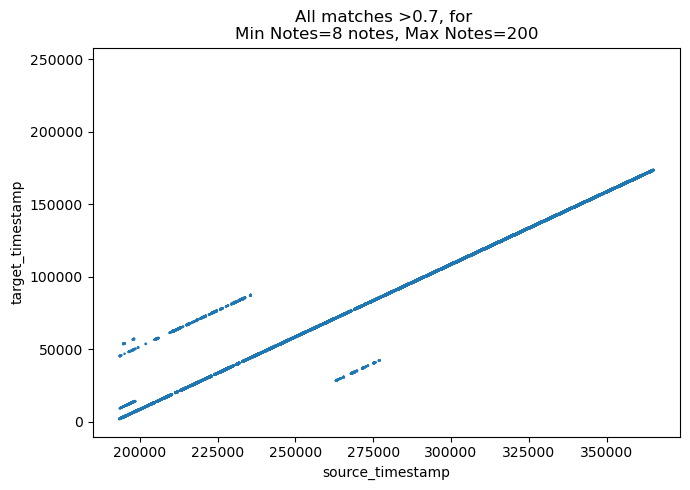

In [126]:
# plotting all matches with score > threshold
# plot of source timestamp vs target timestamp

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

title = "All matches >"+str(thresh)+", for \nMin Notes=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes)
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)


Percentage matches found: 98.8%
Percentage matches >0.7 found: 96.9%
Percentage matches within 50ms of line: 93.2%
Percentage matches >0.7 and within 50ms of the line: 91.9%
Minimum score of a "right match": 0.50



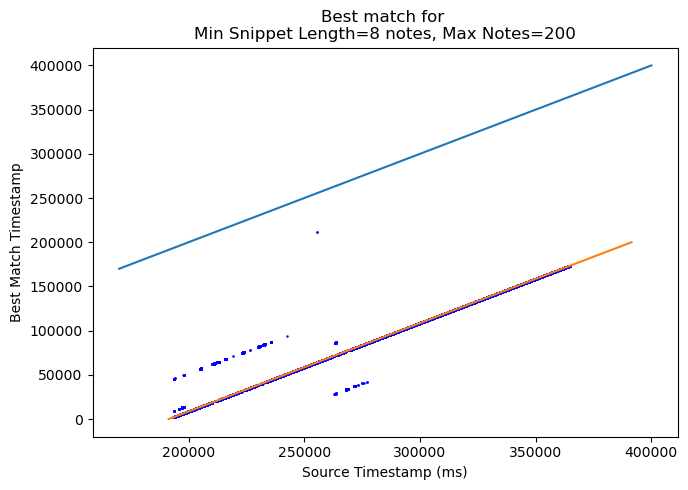

In [127]:
# Plotting best match only for each source timestamp
# plot of source timestamp vs target timestamp
# blue line is current playthrough (if match was found at current timestamp - not allowed)
# orange line is previous playthrough (corresponds to "expected match" if both playthroughs were identical)
# "on the line" refers to match very close to orange line; within acc ms

# Caluculating statistics of matches
percentage_matches_any = 0
percentage_matches_thresh = 0
percentage_matches_line = 0
percentage_matches_thresh_line = 0
min_good_score = 1

# accuracy within which we want to plot distribution of notes 
# ms within which we consider match "on the line"
acc = 50

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

toPlot = simsDFall
# toPlot = simsDFall_old

# params calculated to use in subsequent plots
distribution_hist = [] # distribution of distance from line for matches "on the line"
distribution_all = [] # distance from line for matches "on the line" for each source timestamp
close_matches = [] # array of matches "on the line"
bestMatches = [] # array of only best matches for each source timestamp

# Looping over source timestamps (timestaps for which we have matches)
for x in range(start,end,skip):
    y = toPlot.loc[toPlot['source_timestamp'] == x]['score']
    if y.any(): 
        y = y.idxmax()
        percentage_matches_any += 1
        if toPlot['score'].loc[y] > thresh:
            percentage_matches_thresh += 1
            if np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))<acc:
                percentage_matches_thresh_line += 1
        if np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))<acc:
            if toPlot['score'].loc[y] < min_good_score:
                min_good_score = toPlot['score'].loc[y]
            distribution_hist.append((toPlot['target_timestamp'].loc[y]-(x-191400)))
            distribution_all.append([x,(toPlot['target_timestamp'].loc[y]-(x-191400))])
            percentage_matches_line += 1
            close_matches.append(toPlot.loc[y].tolist())
    else:
        continue
#     bestMatch = [toPlot['source_timestamp'].loc[y],toPlot['target_timestamp'].loc[y],toPlot['score'].loc[y],toPlot['source_id_start'].loc[y],toPlot['source_id_end'].loc[y],toPlot['target_id_start'].loc[y],toPlot['target_id_end'].loc[y]]
#     bestMatches.append(bestMatch)
    plt.scatter(toPlot['source_timestamp'].loc[y],toPlot['target_timestamp'].loc[y],toPlot['score'].loc[y],c='blue')
# bestMatches = np.array(bestMatches)
# bestMatchesDF = pd.DataFrame(data=bestMatches, columns=["source_timestamp","target_timestamp", "score", "source_id_start", "source_id_end", "target_id_start", "target_id_end"])   


# blue line is current playthrough (if match was found at current timestamp - not allowed)
plt.plot(np.arange(170000,400000),np.arange(170000,400000))
# orange line is previous playthrough (corresponds to "expected match" if both playthroughs were identical)
plt.plot(np.arange(191400,391400),np.arange(200000))

total = len(curr_times) # Total number of source timestamps
percentage_matches_any /= total
percentage_matches_thresh /= total
percentage_matches_line /= total
percentage_matches_thresh_line /= total
print("Percentage matches found: {:.1f}%".format(percentage_matches_any*100))
print("Percentage matches >{:.1f} found: {:.1f}%".format(thresh,percentage_matches_thresh*100))
print("Percentage matches within {:d}ms of line: {:.1f}%".format(acc,percentage_matches_line*100))
print("Percentage matches >{:.1f} and within {:d}ms of the line: {:.1f}%".format(thresh,acc,percentage_matches_thresh_line*100))
print("Minimum score of a \"right match\": {:.2f}".format(min_good_score))
print()
# print("Number of loops sped up: {:d}".format(num_speedups))
# print("Percentage loops sped up: {:.2f} - rough estimate".format((num_speedups/(len(curr_times)))*100))

plt.title("Best match for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Timestamp")
plt.show()


Distribution Mean:-1.49
Distribution Standad Deviation:9.17


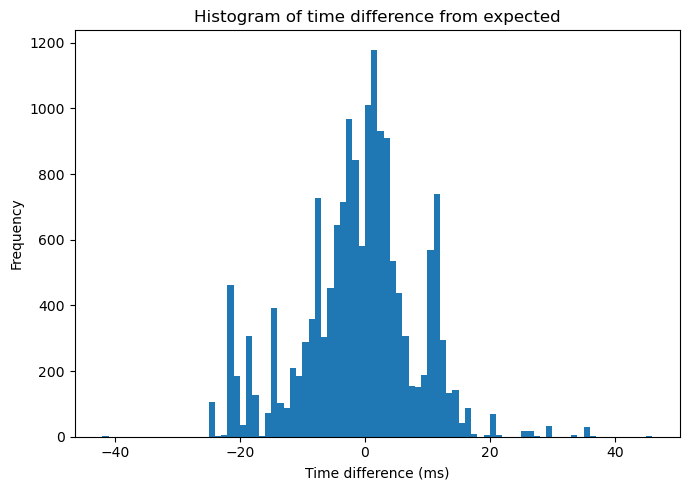

In [128]:
# plotting histogram of notes "on the line"
# OR plotting distance from the line for a "correct match"
# OR plotting difference between "correct match" and "expected match"
mean = np.mean(distribution_hist)
std = np.std(distribution_hist)
print("Distribution Mean:{:.2f}".format(mean))
print("Distribution Standad Deviation:{:.2f}".format(std))
plt.hist(distribution_hist,bins=int(max(distribution_hist)-min(distribution_hist)))
plt.title("Histogram of time difference from expected")
plt.xlabel("Time difference (ms)")
plt.ylabel("Frequency")
plt.show()

Distribution Mean:5.05
Distribution Standad Deviation:29.32


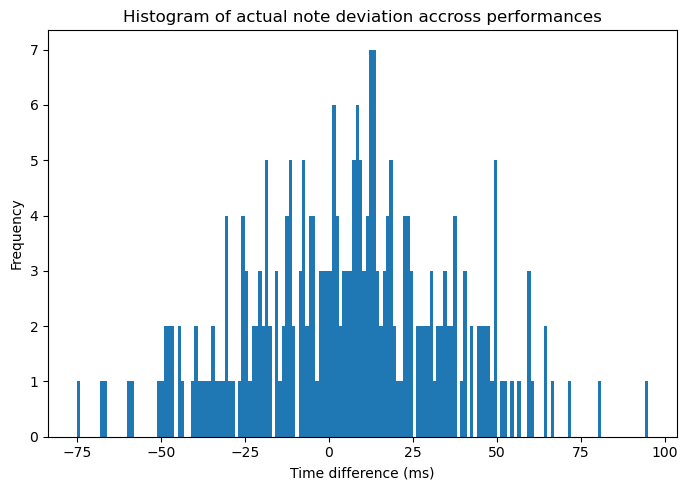

In [129]:
# Note distribution in first vs second playthrough

note_distribution_hist = []
for note in notes[time_to_index(notes,start):time_to_index(notes,end)]:
    # find closest note in history
    note2 = find_note(notes, note[0]-191400, note[1], max_time_dist = 100)
    if note2:
        note_distribution_hist.append(note[0]-notes[note2][0]-191400)
    
mean = np.mean(note_distribution_hist)
std = np.std(note_distribution_hist)
print("Distribution Mean:{:.2f}".format(mean))
print("Distribution Standad Deviation:{:.2f}".format(std))
plt.hist(note_distribution_hist,bins=int(max(note_distribution_hist)-min(note_distribution_hist)))
plt.title("Histogram of actual note deviation accross performances")
plt.xlabel("Time difference (ms)")
plt.ylabel("Frequency")
plt.show()

(16175, 9)
source_timestamp    193470.000000
target_timestamp      2067.000000
score                    0.715674
source_id_start        766.000000
source_id_end          758.000000
target_id_start          6.000000
target_id_end            2.000000
match_len                8.000000
match_time            1796.000000
deviation               -3.000000
Name: 0, dtype: float64
(1, 10)
[[195210   3856      0    771    758     15      2     13   3536     46]]
[195210   3856      0    771    758     15      2     13   3536     46]


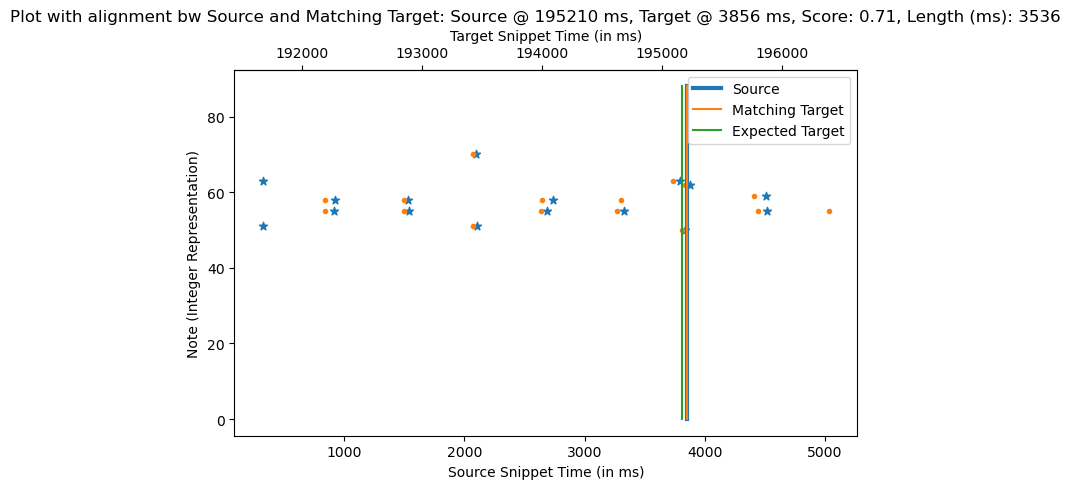

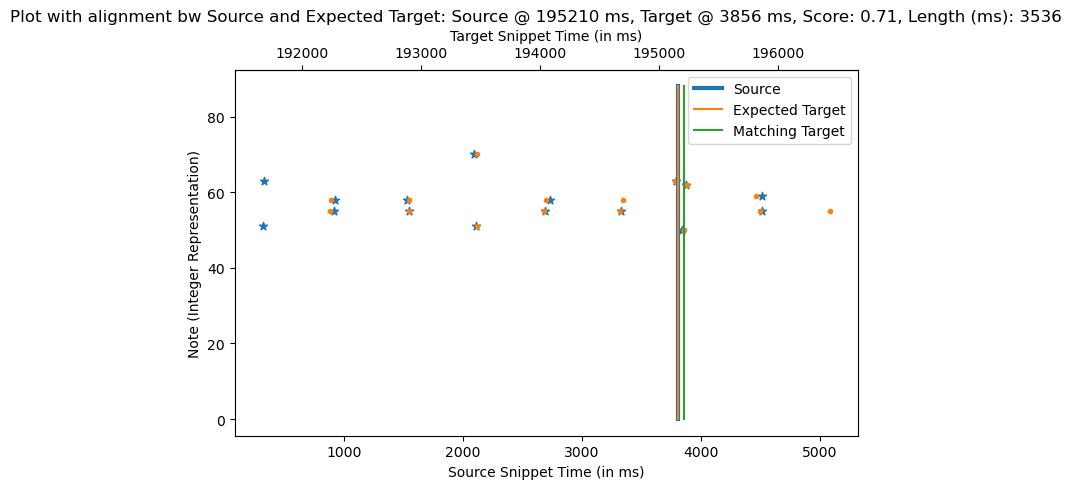

Source end notes:
 [[195144     63     44]
 [195191     50     40]
 [195230     62     56]
 [195868     59     41]
 [195870     55     45]]
Source end notes - 191400: [3744 3791 3830 4468 4470]
Target end notes:
 [[3810   50   49]
 [3832   62   61]
 [4414   59   45]
 [4446   55   49]
 [5035   55   45]]
Source diff between notes: [ 47  39 638   2]
Target diff between notes: [ 22 582  32 589]
Source time - last note: 19.0
Target time - last note: 24.0



In [130]:
# Plotting k worst matches - matches on the line but farthest from it

#['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time']
k = 1

# dtype = [('source_timestamp', float), ('target_timestamp', float), ('score', float),('source_id_start', float),\
#          ('source_id_end', float),('target_id_start', float),('target_id_end', float),('match_len', float),('match_time', float)]

close_matches_array = np.array(close_matches)
distribution_hist_array = np.array(distribution_hist)
print(close_matches_array.shape)
close_matches_df = pd.DataFrame(data = close_matches_array, columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])
close_matches_df['deviation'] = distribution_hist_array

close_matches_sorted = close_matches_df.sort_values(by=['deviation'])

worst_matches = np.array(close_matches_sorted.iloc[-k:],dtype=float)

print(close_matches_df.iloc[0])
print(worst_matches.shape)
print(worst_matches.astype(int))
for match in worst_matches:
    print(match.astype(int))
    source_start = int(match[0])
    target_start = int(match[1])
    score = match[2]
    source_id_start = int(match[3])
    source_id_end = int(match[4])
    target_id_start = int(match[5])
    target_id_end = int(match[6])
    match_len = int(match[7])
    match_time = int(match[8])
    
    # plot worst match (in terms of distance from expected timestamp)
    diff = source_start - target_start
    sequence1 = np.copy(notes[source_id_end:source_id_start+3])
    sequence1[:,0] = sequence1[:,0]-diff
    sequence2 = np.copy(notes[target_id_end:target_id_start+3])
    sequence2[:,0] = sequence2[:,0]
    sequence3 = sequence2.copy()
    sequence3[:,0] = sequence2[:,0]-diff+191400
    
    display_expected_actual(sequence1,sequence2,source_start,target_start,source_start-diff,target_start,source_start-191400,diff,score,match_time,l1="Source",l2="Matching Target",l3="Expected Target")
    display_expected_actual(sequence1,sequence3,source_start,target_start,source_start-191400,source_start-191400,target_start,diff,score,match_time,l1="Source",l2="Expected Target",l3="Matching Target")
    
    a = notes[source_id_start-2:source_id_start+3]
    b = notes[target_id_start-2:target_id_start+3]
    print("Source end notes:\n",a)
    print("Source end notes - 191400:",a[:,0] - 191400)
    print("Target end notes:\n",b)
    print("Source diff between notes:",a[1:,0] - a[:-1,0])
    print("Target diff between notes:",b[1:,0] - b[:-1,0])
    print("Source time - last note:",match[0]-notes[int(match[3])-1][0])
    print("Target time - last note:",match[1]-notes[int(match[5])-1][0])
    print()

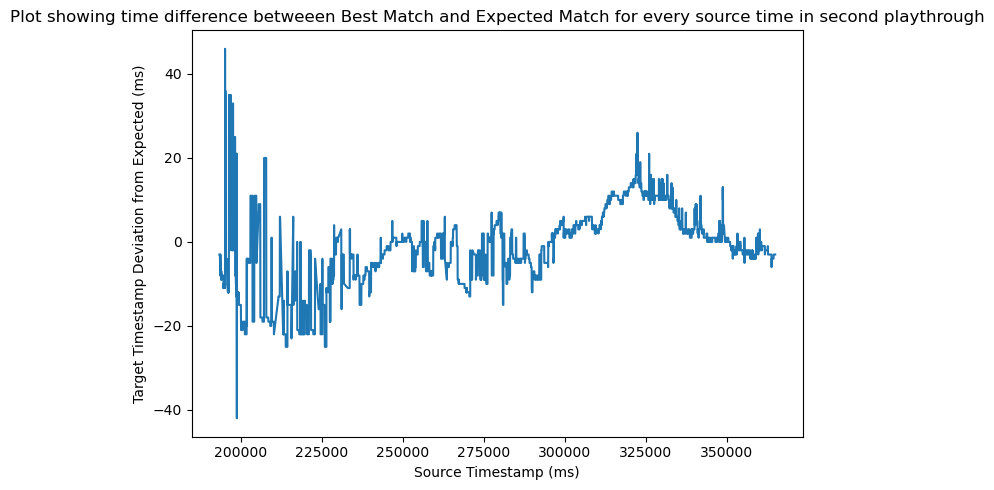

In [131]:
# Plotting distance from line vs source time

distribution_all_arr = np.array(distribution_all)
plt.plot(distribution_all_arr[:,0],distribution_all_arr[:,1])
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Target Timestamp Deviation from Expected (ms)")
plt.title("Plot showing time difference betweeen Best Match and Expected Match for every source time in second playthrough")
plt.show()

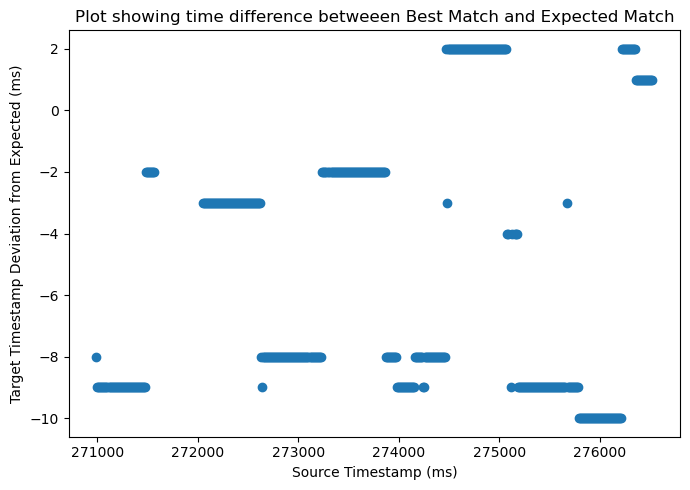

In [132]:
# Plotting distance from line vs source time - within a range of source timestamps

source_time = 275000
index = (source_time - start)//skip
index -= 1500
len_match = 500

# Getting match details near source time we're interested in
# Can use this to make display_snippet plots
# matches_near_source = np.array(close_matches_df.iloc[index:index+500])

distribution_all_arr = np.array(distribution_all)
plt.scatter(distribution_all_arr[index:index+len_match,0],distribution_all_arr[index:index+len_match,1])
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Target Timestamp Deviation from Expected (ms)")
plt.title("Plot showing time difference betweeen Best Match and Expected Match")
plt.show()

In [133]:
# used for legend in below plots
pop_a = mpatches.Patch(color='blue', label='Unexpected match')
pop_b = mpatches.Patch(color='orange', label='On the line match')

207


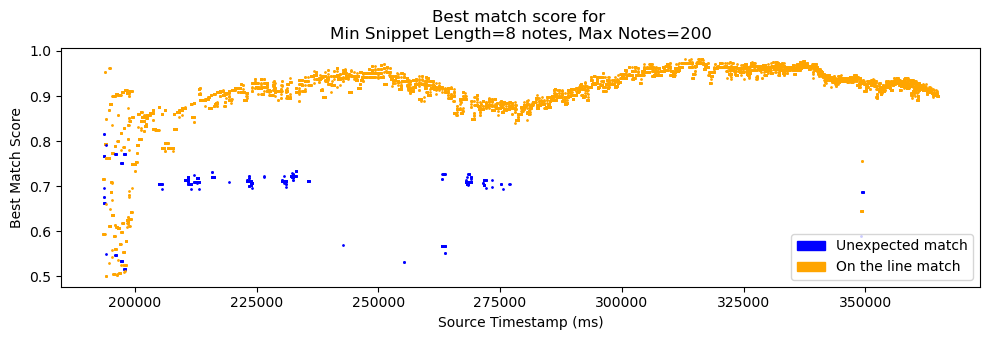

In [134]:
# Plotting best match score 

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in curr_times:
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if np.isnan(y):
        count += 1
        y = 0
    else:
        if (np.abs(simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y) & (simsDFall['match_len'] == s)]['target_timestamp']-(x-191400))<100).any():
            color = 'orange'
        else:
            color = 'blue'
        plt.scatter(x,y,1,c=color) # need to include s (len of best match)

# currDF = simsDFall.copy()
# currDF.sort_values(['source_timestamp', 'score', 'match_len'], ascending=[True, False, False]).drop_duplicates(['source_timestamp']).reset_index(drop=True)
# plt.scatter(curr_times,currDF.loc[currDF['source_timestamp'] == curr_times]['score'],currDF.loc[currDF['source_timestamp'] == curr_times]['match_len'])
# scores = s.max(axis = 0)
# # if np.isnan(y):
# #     count += 1
# #     y = 0
    

print(count)
plt.title("Best match score for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Score")
plt.legend(handles=[pop_a,pop_b])
plt.show()

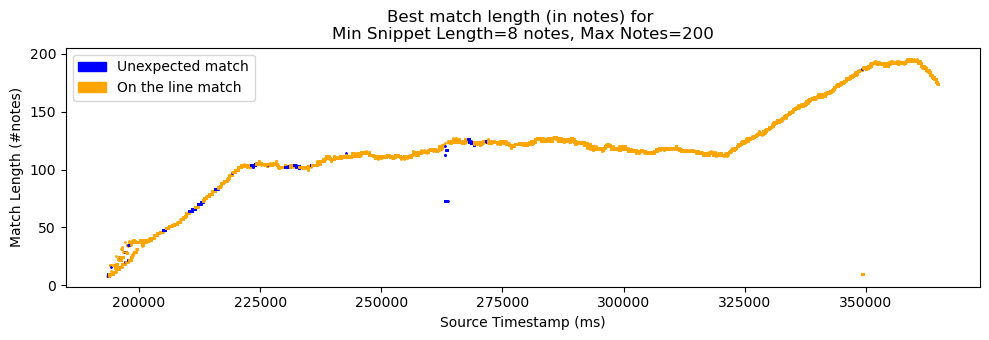

In [135]:
# Plotting note length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if np.isnan(y):
        count += 1
        y = 0
    
    if (np.abs(simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y) & (simsDFall['match_len'] == s)]['target_timestamp']-(x-191400))<100).any():
        color = 'orange'
    else:
        color = 'blue'
    plt.scatter(x,s,1,c=color)
    
# print(count)
plt.title("Best match length (in notes) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Match Length (#notes)")
plt.legend(handles=[pop_a,pop_b])
plt.show()

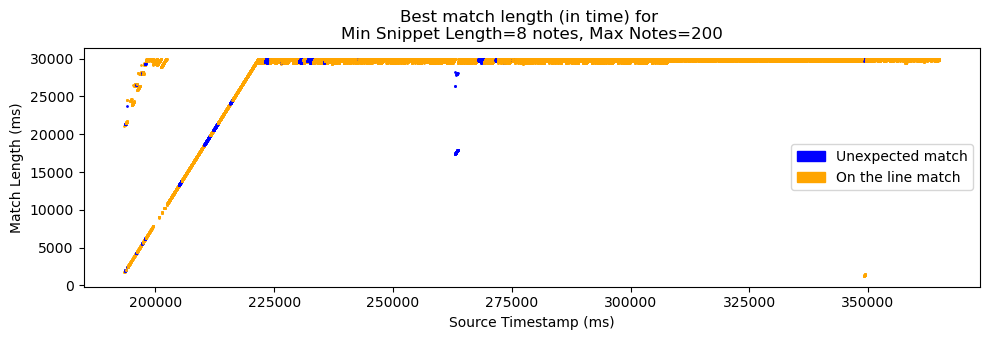

In [136]:
# Plotting time length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_time'].max()
#     print(s)
    if np.isnan(y):
        count += 1
        y = 0
    if (np.abs(simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y) & (simsDFall['match_time'] == s)]['target_timestamp']-(x-191400))<100).any():
        color = 'orange'
    else:
        color = 'blue'
    plt.scatter(x,s,1,c=color)
    
# print(count)
plt.title("Best match length (in time) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Match Length (ms)")
plt.legend(handles=[pop_a,pop_b])
plt.show()